In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

# read data

In [2]:
nodes_addresses = pd.read_csv("./data/nodes-addresses.csv", low_memory=False, index_col=0)
nodes_addresses["node_type"] = ["Address"]*len(nodes_addresses)

nodes_entities = pd.read_csv("./data/nodes-entities.csv", low_memory=False, index_col=0)
nodes_entities["node_type"] = ["Entity"]*len(nodes_entities)

nodes_intermediaries = pd.read_csv("./data/nodes-intermediaries.csv", low_memory=False, index_col=0)
nodes_intermediaries["node_type"] = ["Intermediary"]*len(nodes_intermediaries)

nodes_officers = pd.read_csv("./data/nodes-officers.csv", low_memory=False, index_col=0)
nodes_officers["node_type"] = ["Officer"]*len(nodes_officers)

nodes_others = pd.read_csv("./data/nodes-others.csv", low_memory=False, index_col=0)
nodes_others["node_type"] = ["Other"]*len(nodes_others)

relationships = pd.read_csv("./data/relationships.csv", low_memory=False).set_index(["node_id_start", "node_id_end"])

G = nx.MultiDiGraph() #directed multi-edge graph
G.add_nodes_from([(key, value) for key, value in nodes_addresses.to_dict("index").items()])
G.add_nodes_from([(key, value) for key, value in nodes_entities.to_dict("index").items()])
G.add_nodes_from([(key, value) for key, value in nodes_intermediaries.to_dict("index").items()])
G.add_nodes_from([(key, value) for key, value in nodes_officers.to_dict("index").items()])
G.add_nodes_from([(key, value) for key, value in nodes_others.to_dict("index").items()])
G.add_edges_from([(*relationships.index[i], value) for i, value in enumerate(relationships.to_dict(orient='records'))])

del nodes_addresses
del nodes_entities
del nodes_intermediaries
del nodes_officers
del nodes_others
del relationships

In [3]:
G.size()

3339267

# simplified network

C:\Users\Stephan\AppData\Local\Temp\ipykernel_10516\1926548775.py:51: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(graph, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=2)


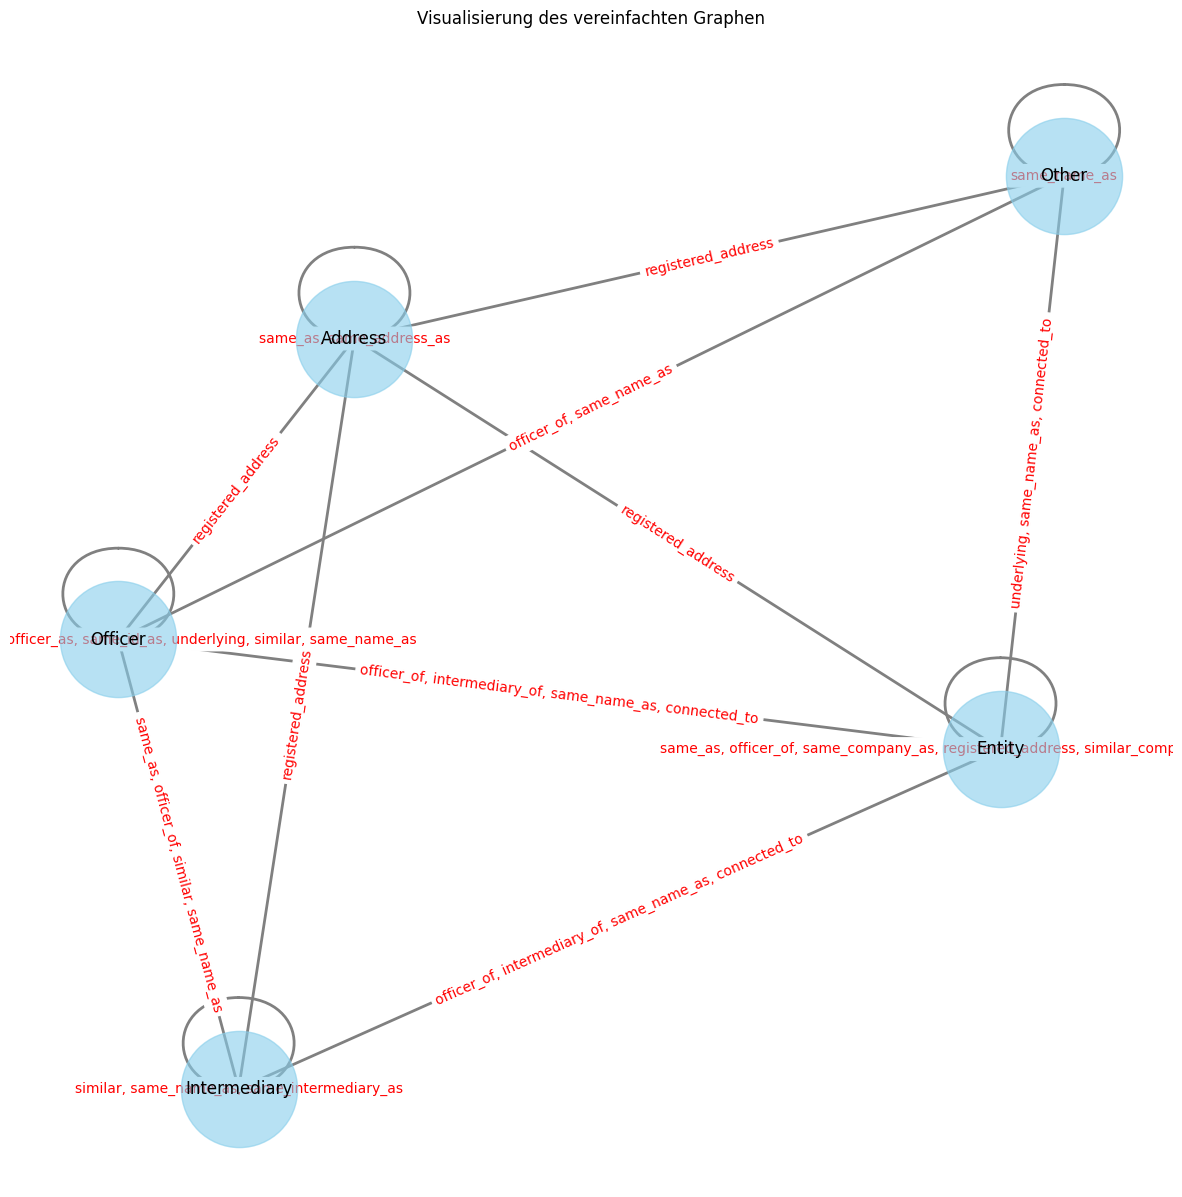

In [40]:
def simplify_graph(graph):
    """
    Vereinfacht einen Graphen, indem Knoten auf Basis des 'node_type' zusammengefasst werden.
    Kanten werden basierend auf dem 'rel_type' zwischen den Knotentypen vereinfacht.
    
    Parameters:
        graph (nx.Graph): Der ursprüngliche Graph mit komplexen Verbindungen und Knotenattributen.
    
    Returns:
        nx.Graph: Ein vereinfachter Graph, der nur Knotentypen und die Verbindungstypen zwischen ihnen zeigt.
    """
    simplified_graph = nx.Graph()

    # Mapping von node_type zu einem eindeutigen Knoten im vereinfachten Graphen
    node_type_map = {}

    # Knoten nach Typ gruppieren
    for node, attr in graph.nodes(data=True):
        node_type = attr.get('node_type', None)
        if node_type not in node_type_map:
            node_type_map[node_type] = node_type
            simplified_graph.add_node(node_type, node_type=node_type)
    
    # Kanten nach Verbindungstyp gruppieren
    for u, v, attributes in graph.edges(data=True):
        u_type = graph.nodes[u].get('node_type', None)
        v_type = graph.nodes[v].get('node_type', None)
        rel_type = attributes.get('rel_type', None)
        
        # Prüfen, ob eine Kante zwischen den Typen bereits existiert
        if simplified_graph.has_edge(u_type, v_type):
            # Fügen den neuen Verbindungstyp hinzu, wenn er noch nicht vorhanden ist
            existing_types = simplified_graph[u_type][v_type]['rel_type']
            if rel_type not in existing_types:
                simplified_graph[u_type][v_type]['rel_type'].add(rel_type)
        else:
            # Erstellen der Kante mit einem Set, das den Verbindungstyp enthält
            simplified_graph.add_edge(u_type, v_type, rel_type={rel_type})
    
    return simplified_graph

def draw_graph(graph):
    plt.figure(figsize=(15, 15))
    
    pos = nx.spring_layout(graph)  # Layout der Knoten im Graphen
    
    # Knoten zeichnen
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=7000, alpha=0.6)
    
    # Kanten zeichnen
    nx.draw_networkx_edges(graph, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=2)
    
    # Knotenbeschriftungen hinzufügen
    node_labels = {node: f"{data['node_type']}" for node, data in graph.nodes(data=True)}
    nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=12)
    
    # Kantenbeschriftungen hinzufügen
    edge_labels = {(u, v): ', '.join(data['rel_type']) for u, v, data in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title('Visualisierung des vereinfachten Graphen')
    plt.axis('off')  # Achsen ausschalten
    plt.show()

draw_graph(simplify_graph(G))

# transform network

In [39]:
two_mode = nx.DiGraph(nx.subgraph_view(G, filter_node=lambda x: G.nodes[x]["node_type"] in ("Officer", "Entity"), filter_edge=lambda x,y,z: G.nodes[x]["node_type"] != G.nodes[y]["node_type"]))

C:\Users\Stephan\AppData\Local\Temp\ipykernel_10516\1926548775.py:51: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(graph, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=2)


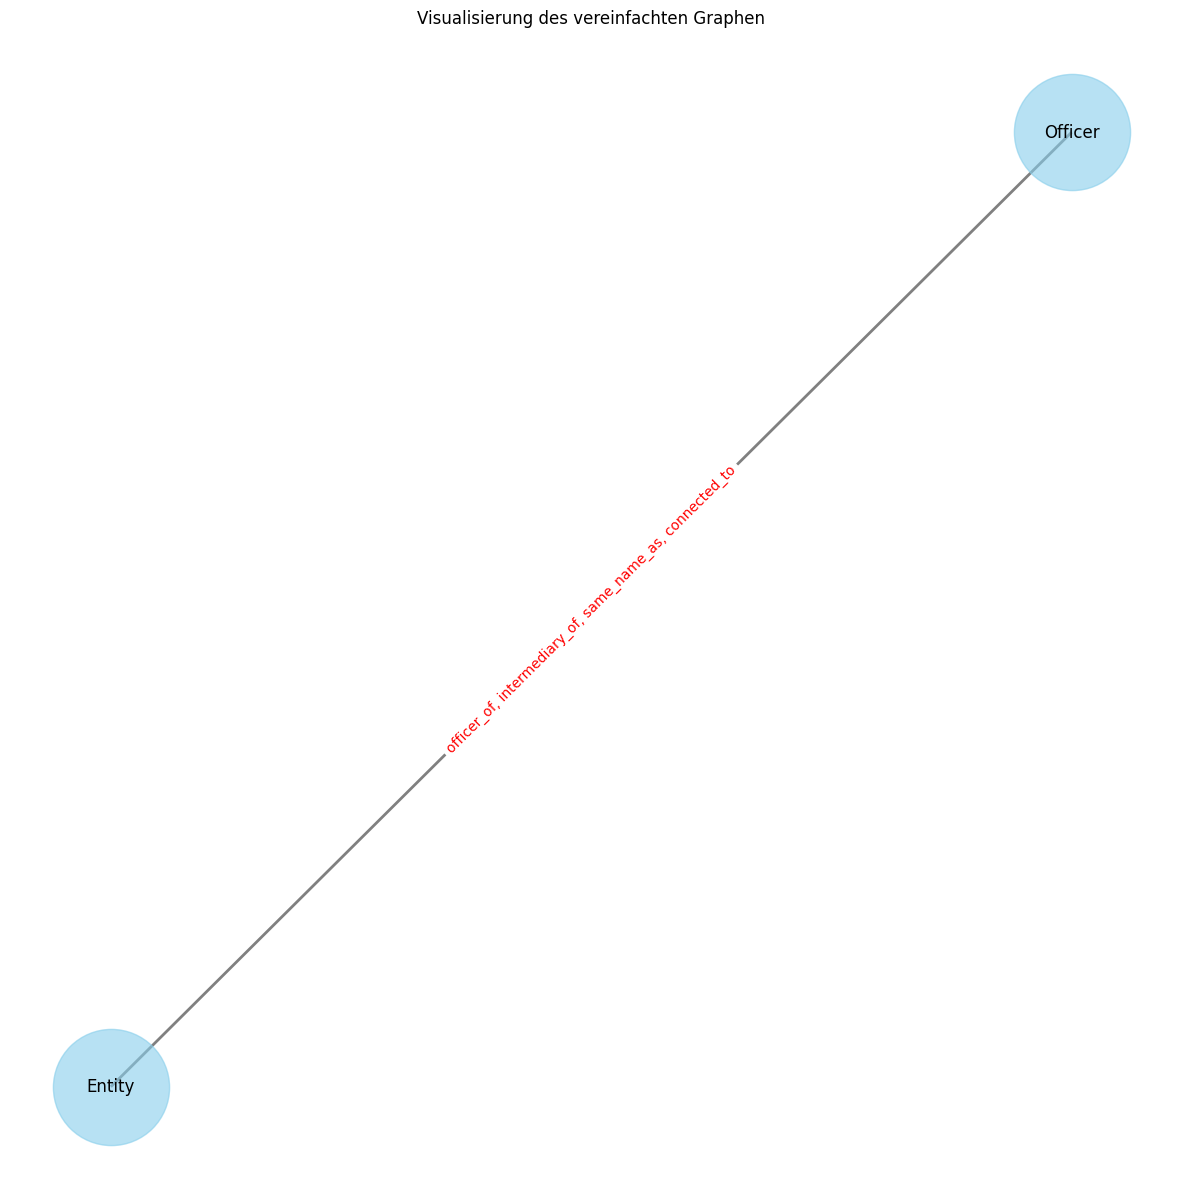

In [41]:
draw_graph(simplify_graph(two_mode))

In [43]:
one_mode = nx.algorithms.bipartite.weighted_projected_graph(two_mode, [node for node, data in two_mode.nodes(data=True) if data["node_type"] == "Officer"])

C:\Users\Stephan\AppData\Local\Temp\ipykernel_10516\1926548775.py:51: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(graph, pos, arrowstyle='-|>', arrowsize=20, edge_color='gray', width=2)


TypeError: sequence item 0: expected str instance, NoneType found

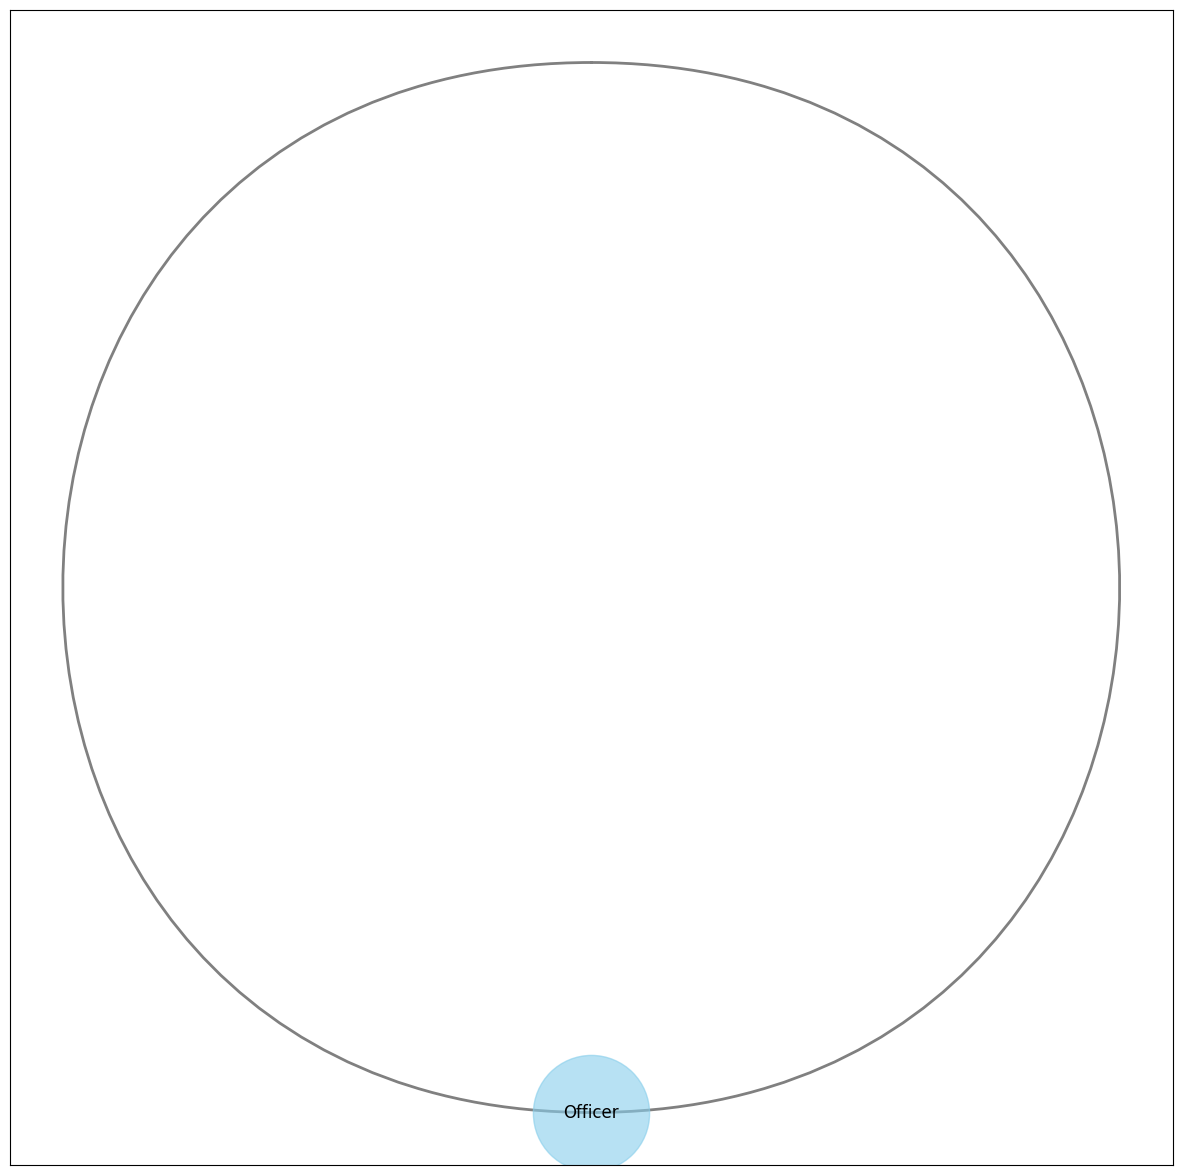

In [44]:
draw_graph(simplify_graph(one_mode))

# connected components

In [51]:
one_mode.number_of_nodes()

771315

In [50]:
nx.number_weakly_connected_components(one_mode)

769840